# Load and unzip data

In [1]:
import zipfile
import os
import pandas as pd
from tqdm import tqdm
import cv2
from sklearn.preprocessing import LabelEncoder

# Define the paths
zip_file_path = r'C:\Users\Zoiya\OneDrive\Courses\HAM.zip'
extract_dir = r'C:\Users\Zoiya\OneDrive\Courses\HAM\HAM10000_images'

# Unzip the HAM.zip file to the extract directory
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction complete.")

# Load the Metadata
metadata_path = r'C:\Users\Zoiya\OneDrive\Courses\HAM\HAM10000_metadata.csv'
data = pd.read_csv(metadata_path)

# Look at initial label distribution
print("Initial label distribution:")
print(data['dx'].value_counts())

# Fill missing 'age' values with the median
median_age = data['age'].median()
data['age'].fillna(median_age, inplace=True)



Extraction complete.
Initial label distribution:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


C:\Users\Zoiya\AppData\Local\Temp\ipykernel_14296\3592732841.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['age'].fillna(median_age, inplace=True)


# Load all images:
    # Print which images are missing

In [2]:
# Define image directories
image_dirs = [
    r'C:\Users\Zoiya\OneDrive\Courses\HAM\HAM10000_images_part_1',
    r'C:\Users\Zoiya\OneDrive\Courses\HAM\HAM10000_images_part_2'
]

# Verify image paths and load images
valid_images = []
missing_images = []
for index, row in data.iterrows():
    img_id = row['image_id']
    img_path = None
    for dir in image_dirs:
        potential_path = os.path.join(dir, f'{img_id}.jpg')
        if os.path.exists(potential_path):
            img_path = potential_path
            break
    if img_path and os.path.exists(img_path):
        img = cv2.imread(img_path)
        if img is not None:
            valid_images.append((img_id, img))
        else:
            missing_images.append(img_id)
            print(f"Failed to load image {img_id} from path: {img_path}")
    else:
        missing_images.append(img_id)
        print(f"Image {img_id} not found at path: {img_path}")

print(f"Successfully loaded {len(valid_images)} images")
print(f"Missing images: {missing_images}")


Successfully loaded 10015 images
Missing images: []


# Plot distribution

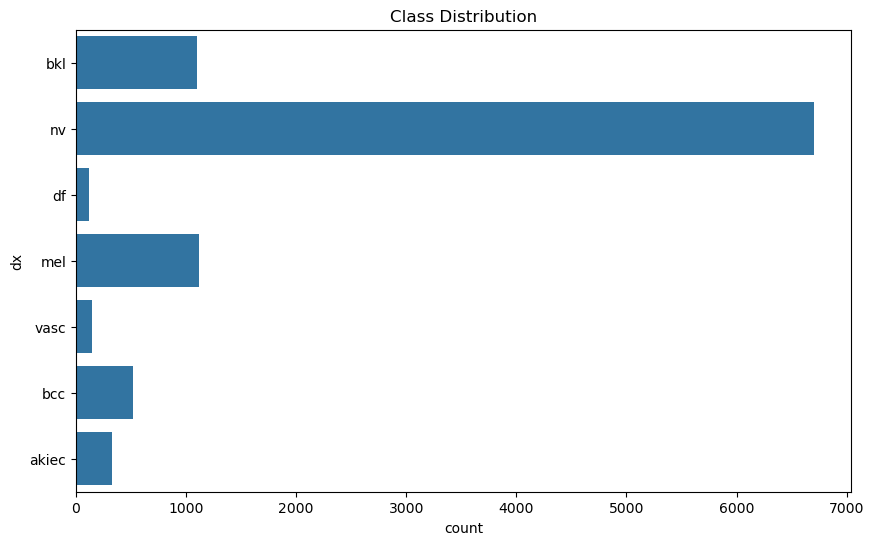

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# View the distribution of labels
plt.figure(figsize=(10, 6))
sns.countplot(data['dx'])
plt.title('Class Distribution')
plt.show()

# Preprocessing:

Resample so every class has 500 maximum

In [4]:
from sklearn.utils import resample

# Group by class
grouped_data = data.groupby('dx')

# Downsample majority classes to 500 samples each, keeping minority classes as is
downsampled_data = pd.DataFrame()
for dx, group in grouped_data:
    if len(group) > 500:
        downsampled_group = resample(group, replace=False, n_samples=500, random_state=123)
    else:
        downsampled_group = group
    downsampled_data = pd.concat([downsampled_data, downsampled_group])

# Check downsampled class distribution
print("Downsampled class distribution:")
print(downsampled_data['dx'].value_counts())


Downsampled class distribution:
dx
bcc      500
bkl      500
mel      500
nv       500
akiec    327
vasc     142
df       115
Name: count, dtype: int64


# Compute class weights
weight = total samples/(number of classes x number of samples in class)

In [5]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(downsampled_data['dx'].values)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels_encoded), y=labels_encoded)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class Weights:", class_weight_dict)

Class Weights: {0: 1.128877238968982, 1: 0.7382857142857143, 2: 0.7382857142857143, 3: 3.2099378881987577, 4: 0.7382857142857143, 5: 0.7382857142857143, 6: 2.5995975855130786}


# Preprocess images
    # Check which images are missing or valid
    # Preprocess images by...
        # Resizing them all to 224 x 224, (best for ResNet)
        # Grayscale
        # Normalize pixel values
    # Augment images by...
        # Horizontal and vertical flip
        # Change brightness
        # Change contrast
    # Show a processed image
    # Report missing images

Preprocessing Images: 100%|████████████████████████████████████████████████████████| 2584/2584 [00:43<00:00, 59.42it/s]


Successfully preprocessed 2584 images
Missing images: []


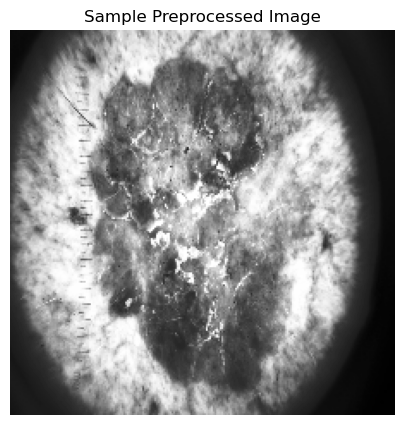

In [6]:
import pandas as pd
import numpy as np
import cv2
import os
from tqdm import tqdm
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt

# Define image directories
image_dirs = [
    r'C:\Users\Zoiya\OneDrive\Courses\HAM\HAM10000_images_part_1',
    r'C:\Users\Zoiya\OneDrive\Courses\HAM\HAM10000_images_part_2'
]

# Verify image paths and preprocess images
valid_images = []
preprocessed_images = []
missing_images = []

# Define augmentations
augmentation_pipeline = iaa.Sequential([
    iaa.Fliplr(0.5),  # horizontal flip
    iaa.Flipud(0.2),  # vertical flip
    iaa.Add((-10, 10)),  # change brightness
    iaa.Multiply((0.8, 1.2))  # change contrast
])

def preprocess_image(img, target_size=(224, 224)):
    img_resized = cv2.resize(img, target_size)
    grayscale_img = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    equalized_img = cv2.equalizeHist(grayscale_img)
    normalized_img = equalized_img / 255.0  # Normalize
    normalized_img = np.expand_dims(normalized_img, axis=-1)
    augmented_img = augmentation_pipeline(image=img_resized)
    return grayscale_img, normalized_img, augmented_img

for index, row in tqdm(downsampled_data.iterrows(), total=downsampled_data.shape[0], desc="Preprocessing Images"):
    img_id = row['image_id']
    img_path = None
    for dir in image_dirs:
        potential_path = os.path.join(dir, f'{img_id}.jpg')
        if os.path.exists(potential_path):
            img_path = potential_path
            break
    if img_path and os.path.exists(img_path):
        img = cv2.imread(img_path)
        if img is not None:
            original_img = img  # Save the original image before any processing
            grayscale_img, normalized_img, augmented_img = preprocess_image(img)
            preprocessed_images.append(normalized_img)  # Preprocessed image for SIFT
            valid_images.append((original_img, grayscale_img, normalized_img))  # Track valid images
        else:
            missing_images.append(img_id)
            print(f"Failed to load image {img_id} from path: {img_path}")
    else:
        missing_images.append(img_id)
        print(f"Image {img_id} not found at path: {img_path}")

print(f"Successfully preprocessed {len(preprocessed_images)} images")
print(f"Missing images: {missing_images}")

# Display a sample preprocessed image
plt.figure(figsize=(5, 5))
plt.imshow(preprocessed_images[0].squeeze(), cmap='gray')
plt.title('Sample Preprocessed Image')
plt.axis('off')
plt.show()


# SIFT
    # Capture keypoints
    # Current hyperparameters--higher contrast threshold (discards more keypoints), higher edge threshhold (more leniency for edges), lower sigma (captures finer keypoints)
    # Checks for missing embeddings
    # Pads embeddings to the same length
    # Displays keypoints on an image

Capturing SIFT Embeddings: 100%|███████████████████████████████████████████████████| 2584/2584 [01:07<00:00, 38.40it/s]


Padded 2581 embeddings successfully.
Padded SIFT embeddings saved to padded_sift_embeddings.npy


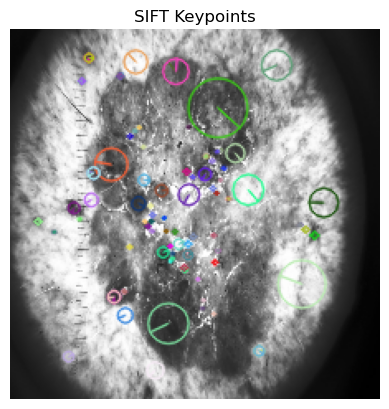

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Use SIFT to capture embeddings and ensure they're non-empty
def capture_sift_embeddings(img, num_keypoints=100, contrast_threshold=0.1, edge_threshold=20, sigma=1.2): # 50 keypoints
    sift = cv2.SIFT_create(contrastThreshold=contrast_threshold, edgeThreshold=edge_threshold, sigma=sigma)
    keypoints, descriptors = sift.detectAndCompute(img, None)
    
    if keypoints is not None and descriptors is not None:
        if len(keypoints) > num_keypoints:
            sorted_indices = np.argsort([kp.response for kp in keypoints])[::-1]  # Sort by response
            keypoints = [keypoints[i] for i in sorted_indices[:num_keypoints]]
            descriptors = descriptors[sorted_indices[:num_keypoints]]
        return keypoints, descriptors
    else:
        return None, None

# Function to display an image
def display_image(image, title="Image", cmap='gray'):
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Capture SIFT embeddings for all preprocessed images
all_embeddings = []
sift_valid_images = []  # Separate list for SIFT processing

for img in tqdm(preprocessed_images, desc="Capturing SIFT Embeddings"):
    if img is not None:
        # Ensure the image is in the correct format (CV_8U)
        img_uint8 = (img.squeeze() * 255).astype(np.uint8)
        keypoints, descriptors = capture_sift_embeddings(img_uint8)
        if descriptors is not None:
            all_embeddings.append(descriptors)
            sift_valid_images.append((img_uint8, keypoints))  # Track valid images and keypoints for SIFT

# Check if embeddings list is empty or contains "None"
if not all_embeddings or all(all_emb is None for all_emb in all_embeddings):
    print("No valid embeddings found. Please check the images and SIFT processing.")
else:
    # Proceed with padding if embeddings are valid
    max_length = max([desc.shape[0] for desc in all_embeddings if desc is not None])
    padded_embeddings = np.array([np.pad(desc, ((0, max_length - desc.shape[0]), (0, 0)), 'constant') if desc is not None else np.zeros((max_length, 128)) for desc in all_embeddings])
    print(f"Padded {len(padded_embeddings)} embeddings successfully.")

    # Save the padded embeddings for six models
    embeddings_path = 'padded_sift_embeddings.npy'
    np.save(embeddings_path, padded_embeddings)
    print(f"Padded SIFT embeddings saved to {embeddings_path}")

# Display keypoints on one image
if sift_valid_images:
    img_uint8, keypoints = sift_valid_images[0]
    img_with_keypoints = cv2.drawKeypoints(img_uint8, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    # Display image with SIFT keypoints
    display_image(img_with_keypoints, title="SIFT Keypoints")


# Ensure the correct number of images and labels are still present

In [8]:
# Print the first few elements of valid_images
for idx, item in enumerate(valid_images[:5]):
    print(f"Item {idx}: {item}")


Item 0: (array([[[20, 15, 30],
        [17, 14, 29],
        [18, 15, 30],
        ...,
        [24, 17, 32],
        [22, 15, 30],
        [22, 15, 30]],

       [[16, 16, 30],
        [17, 14, 30],
        [18, 18, 32],
        ...,
        [21, 16, 31],
        [23, 15, 32],
        [23, 16, 31]],

       [[17, 14, 29],
        [17, 14, 29],
        [18, 15, 30],
        ...,
        [24, 18, 37],
        [25, 17, 34],
        [23, 15, 32]],

       ...,

       [[40, 34, 57],
        [41, 34, 61],
        [42, 34, 64],
        ...,
        [ 0,  1,  9],
        [ 0,  1,  9],
        [ 0,  1,  9]],

       [[39, 33, 58],
        [38, 33, 60],
        [38, 33, 62],
        ...,
        [ 0,  1,  9],
        [ 0,  1,  9],
        [ 0,  1,  9]],

       [[39, 31, 61],
        [38, 33, 60],
        [38, 33, 60],
        ...,
        [ 0,  1,  9],
        [ 0,  1,  9],
        [ 0,  1,  9]]], dtype=uint8), array([[19, 20, 21, ..., 26, 24, 21],
       [19, 21, 21, ..., 26, 24, 23],
      

In [9]:
# Print number of labels
print("Number of columns in downsampled_data:", len(downsampled_data.columns))


Number of columns in downsampled_data: 7


Ensure images are associated with the correct labels and are still balanced

In [10]:
import pandas as pd

# Create a DataFrame to store the association between image_id, label, and preprocessed image
image_data = []

# Iterate through valid images and associate them with their labels
for idx, (original_img, grayscale_img, normalized_img) in enumerate(valid_images):
    image_id = downsampled_data.iloc[idx]['image_id']
    label = downsampled_data.iloc[idx]['dx']
    image_data.append({'image_id': image_id, 'label': label, 'preprocessed_image': normalized_img})

# Create a DataFrame from the list
preprocessed_data_df = pd.DataFrame(image_data)

# Display the head of the DataFrame to ensure it's correct
print(preprocessed_data_df.head())

# Print the count of each label in the new DataFrame
print("Label distribution in preprocessed data:")
print(preprocessed_data_df['label'].value_counts())

# Save the DataFrame to a file for later
preprocessed_data_df.to_csv('preprocessed_data_with_labels.csv', index=False)


       image_id  label                                 preprocessed_image
0  ISIC_0029417  akiec  [[[0.03529411764705882], [0.0392156862745098],...
1  ISIC_0029915  akiec  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.003921...
2  ISIC_0029360  akiec  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...
3  ISIC_0026152  akiec  [[[0.6470588235294118], [0.6078431372549019], ...
4  ISIC_0029659  akiec  [[[0.2823529411764706], [0.3058823529411765], ...
Label distribution in preprocessed data:
label
bcc      500
bkl      500
mel      500
nv       500
akiec    327
vasc     142
df       115
Name: count, dtype: int64


# Training Models:

In [11]:
# Flatten SIFT embeddings
flattened_embeddings = padded_embeddings.reshape(padded_embeddings.shape[0], -1)

print(f"Shape of flattened embeddings: {flattened_embeddings.shape}")



Shape of flattened embeddings: (2581, 12800)


In [12]:
from sklearn.preprocessing import LabelEncoder

# Load the labels from the downsampled dataset
labels = downsampled_data['dx'].values

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)


Flattened embeddings debugging

In [13]:
# Print the lengths of both arrays
print("Length of flattened_embeddings:", len(flattened_embeddings))
print("Length of labels_encoded:", len(labels_encoded))

# Check the index where the mismatch might occur
for i in range(min(len(flattened_embeddings), len(labels_encoded))):
    if flattened_embeddings[i] is None or labels_encoded[i] is None:
        print(f"Mismatch at index {i}")


Length of flattened_embeddings: 2581
Length of labels_encoded: 2584


In [14]:
# Verify if there are any missing or extra labels in the downsampled_data
embedding_ids = set(downsampled_data.iloc[:len(flattened_embeddings)]['image_id'])
label_ids = set(downsampled_data['image_id'])

# Print the difference
missing_labels = label_ids - embedding_ids
extra_embeddings = embedding_ids - label_ids

print(f"Missing labels: {missing_labels}")
print(f"Extra embeddings: {extra_embeddings}")


Missing labels: {'ISIC_0025452', 'ISIC_0027269', 'ISIC_0026349'}
Extra embeddings: set()


Correct mismatches as long as they are small

In [15]:
# Get the indices of the rows with missing labels
missing_indices = downsampled_data[downsampled_data['image_id'].isin(missing_labels)].index

# Drop these rows from downsampled_data
downsampled_data_cleaned = downsampled_data.drop(missing_indices).reset_index(drop=True)

# Verify the new length
print("New length of downsampled_data:", len(downsampled_data_cleaned))


New length of downsampled_data: 2581


Double-check embeddings match labels now

In [16]:
# Flatten SIFT embeddings
flattened_embeddings = padded_embeddings.reshape(padded_embeddings.shape[0], -1)

# Load the labels from the cleaned dataset
labels_cleaned = downsampled_data_cleaned['dx'].values

# Encode labels
label_encoder = LabelEncoder()
labels_encoded_cleaned = label_encoder.fit_transform(labels_cleaned)

# Check lengths to ensure they match
print("Length of flattened_embeddings:", len(flattened_embeddings))
print("Length of labels_encoded:", len(labels_encoded_cleaned))


Length of flattened_embeddings: 2581
Length of labels_encoded: 2581


Create a 80-20 split of the data--verify shape

In [17]:
from sklearn.model_selection import train_test_split

# Create train/test split with a fixed seed
X_train, X_test, y_train, y_test = train_test_split(flattened_embeddings, labels_encoded_cleaned, test_size=0.2, random_state=42)

# Verifying the split
print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")


Training data shape: (2064, 12800), Training labels shape: (2064,)
Test data shape: (517, 12800), Test labels shape: (517,)


# SVM:

SVM Classification Report:
              precision    recall  f1-score   support

       akiec       0.17      0.01      0.03        68
         bcc       0.25      0.67      0.36        99
         bkl       0.22      0.10      0.14       110
          df       0.00      0.00      0.00        24
         mel       0.33      0.40      0.36        99
          nv       0.28      0.22      0.25        91
        vasc       0.00      0.00      0.00        26

    accuracy                           0.27       517
   macro avg       0.18      0.20      0.16       517
weighted avg       0.23      0.27      0.21       517



C:\Users\Zoiya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Zoiya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Zoiya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVM Accuracy: 0.26692456479690524
SVM AUC-ROC: 0.6255905125406939


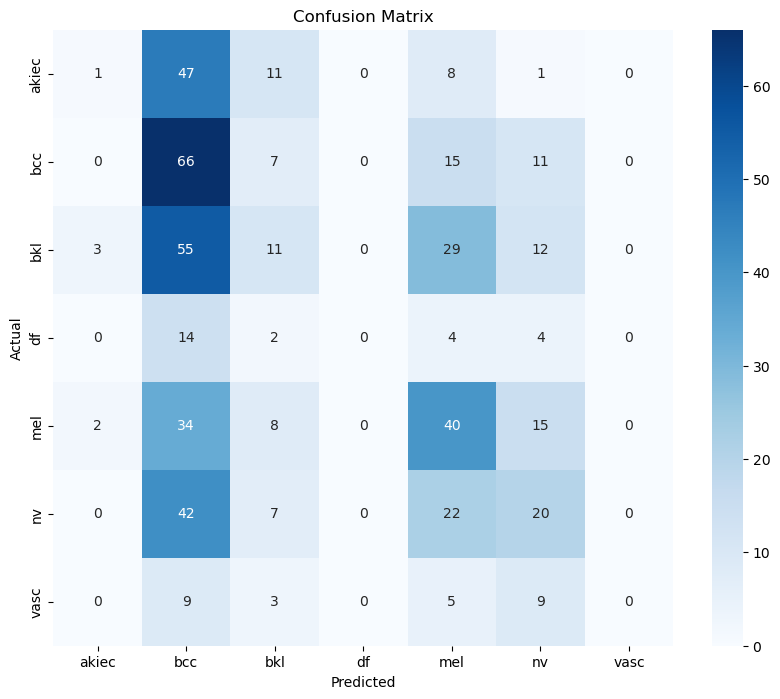

In [18]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix

# Train SVM model
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = svm_model.predict(X_test)
y_pred_prob = svm_model.predict_proba(X_test)

print("SVM Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print(f"SVM Accuracy: {svm_model.score(X_test, y_test)}")
print(f"SVM AUC-ROC: {roc_auc_score(y_test, y_pred_prob, multi_class='ovr')}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



# KNN:

KNN Classification Report:
              precision    recall  f1-score   support

       akiec       0.13      0.04      0.07        68
         bcc       0.28      0.11      0.16        99
         bkl       0.23      0.28      0.25       110
          df       0.00      0.00      0.00        24
         mel       0.29      0.26      0.27        99
          nv       0.20      0.47      0.28        91
        vasc       0.22      0.08      0.11        26

    accuracy                           0.22       517
   macro avg       0.19      0.18      0.16       517
weighted avg       0.22      0.22      0.20       517

KNN Accuracy: 0.22437137330754353
KNN AUC-ROC: 0.5533859924370795


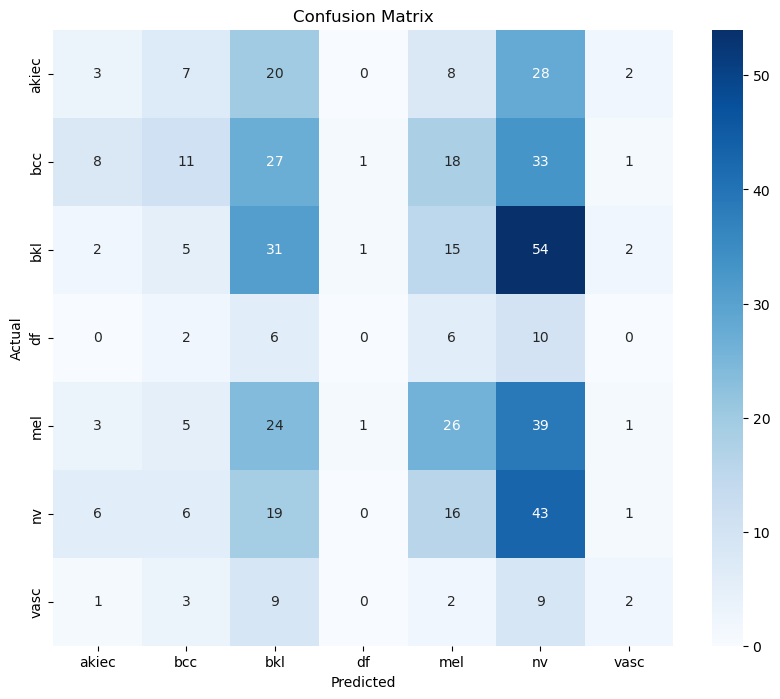

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Train KNN model
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = knn_model.predict(X_test)
y_pred_prob = knn_model.predict_proba(X_test)

print("KNN Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print(f"KNN Accuracy: {knn_model.score(X_test, y_test)}")
print(f"KNN AUC-ROC: {roc_auc_score(y_test, y_pred_prob, multi_class='ovr')}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Random Forest:

Random Forest Classification Report:
              precision    recall  f1-score   support

       akiec       0.14      0.04      0.07        68
         bcc       0.28      0.55      0.37        99
         bkl       0.20      0.16      0.18       110
          df       0.00      0.00      0.00        24
         mel       0.32      0.39      0.35        99
          nv       0.26      0.25      0.25        91
        vasc       0.00      0.00      0.00        26

    accuracy                           0.26       517
   macro avg       0.17      0.20      0.17       517
weighted avg       0.22      0.26      0.23       517

Random Forest Accuracy: 0.26499032882011603
Random Forest AUC-ROC: 0.6001175608420998


C:\Users\Zoiya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Zoiya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Zoiya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


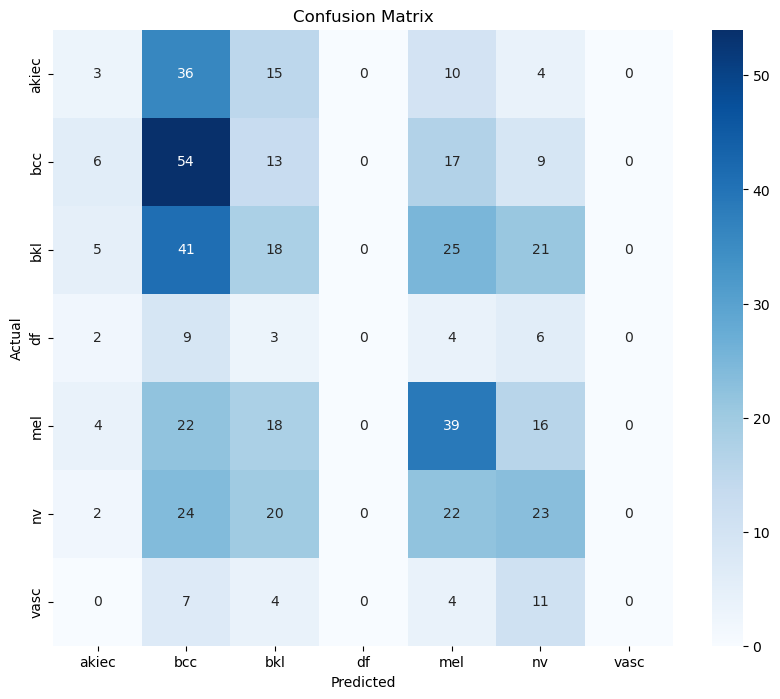

In [20]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print(f"Random Forest Accuracy: {rf_model.score(X_test, y_test)}")
print(f"Random Forest AUC-ROC: {roc_auc_score(y_test, y_pred_prob, multi_class='ovr')}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Decision Tree:

Decision Tree Classification Report:
              precision    recall  f1-score   support

       akiec       0.12      0.10      0.11        68
         bcc       0.21      0.25      0.23        99
         bkl       0.21      0.16      0.18       110
          df       0.07      0.08      0.08        24
         mel       0.20      0.22      0.21        99
          nv       0.18      0.18      0.18        91
        vasc       0.05      0.04      0.04        26

    accuracy                           0.18       517
   macro avg       0.15      0.15      0.15       517
weighted avg       0.17      0.18      0.17       517

Decision Tree Accuracy: 0.1760154738878143
Decision Tree AUC-ROC: 0.5031733976233513


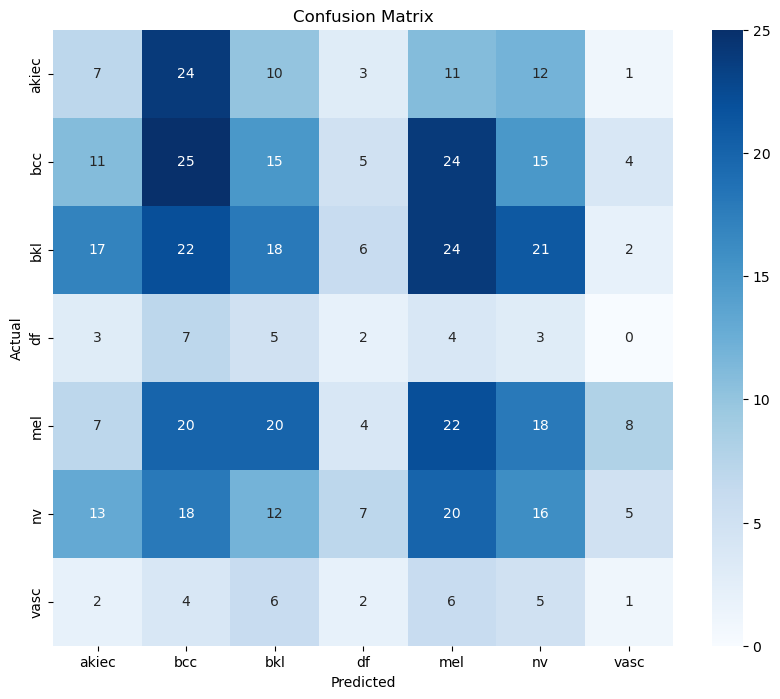

In [21]:
from sklearn.tree import DecisionTreeClassifier

# Train Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = dt_model.predict(X_test)
y_pred_prob = dt_model.predict_proba(X_test)

print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print(f"Decision Tree Accuracy: {dt_model.score(X_test, y_test)}")
print(f"Decision Tree AUC-ROC: {roc_auc_score(y_test, y_pred_prob, multi_class='ovr')}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# XGBoost:

XGBoost Classification Report:
              precision    recall  f1-score   support

       akiec       0.31      0.16      0.21        68
         bcc       0.27      0.41      0.33        99
         bkl       0.22      0.20      0.21       110
          df       0.00      0.00      0.00        24
         mel       0.25      0.29      0.27        99
          nv       0.24      0.29      0.26        91
        vasc       0.00      0.00      0.00        26

    accuracy                           0.25       517
   macro avg       0.18      0.19      0.18       517
weighted avg       0.23      0.25      0.23       517

XGBoost Accuracy: 0.1760154738878143


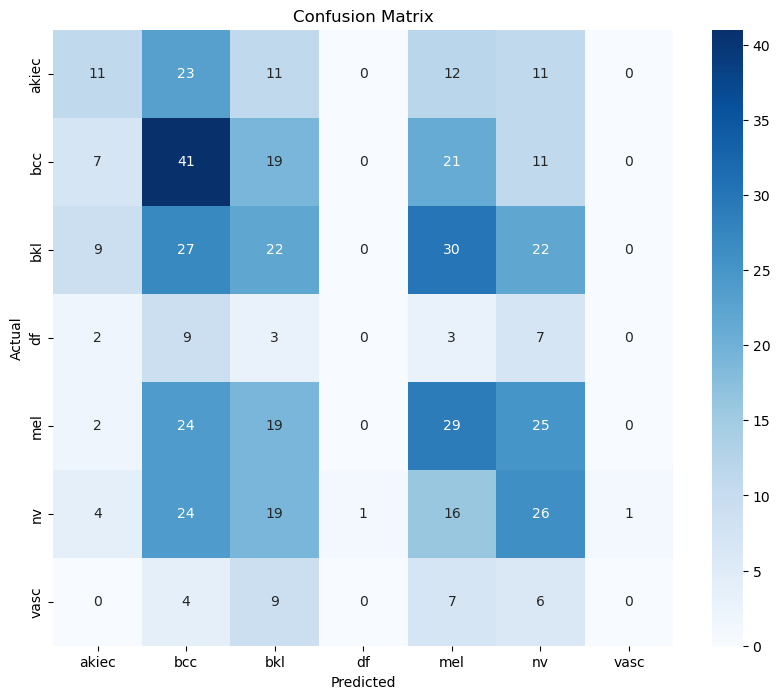

In [22]:
from scipy.sparse import csr_matrix
import xgboost as xgb

# Convert to sparse matrix
X_train_sparse = csr_matrix(X_train)
X_test_sparse = csr_matrix(X_test)

# Train XGBoost model with sparse matrices
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train_sparse, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test_sparse)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print(f"XGBoost Accuracy: {xgb_model.score(X_test, y_test)}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# CNN--no SIFT:

Successfully preprocessed 2584 images


C:\Users\Zoiya\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 289ms/step - accuracy: 0.1799 - loss: 2.7055 - val_accuracy: 0.2657 - val_loss: 1.7923
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 271ms/step - accuracy: 0.2351 - loss: 1.8111 - val_accuracy: 0.2609 - val_loss: 1.7937
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 273ms/step - accuracy: 0.3246 - loss: 1.6845 - val_accuracy: 0.3768 - val_loss: 1.6846
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 275ms/step - accuracy: 0.4363 - loss: 1.4948 - val_accuracy: 0.3671 - val_loss: 1.6812
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 19s 327ms/step - accuracy: 0.5257 - loss: 1.2799 - val_accuracy: 0.3092 - val_loss: 1.8059
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 354ms/step - accuracy: 0.6863 - loss: 0.8995 - val_accuracy: 0.3527 - val_loss: 1.9137
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 385ms/step - accuracy: 0.7880 - loss: 0.6518 - val_accuracy: 0.3478 - val_loss: 2.0799
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 25s 425ms/step - accuracy: 0.8247 - loss: 0.5171 - val_accu

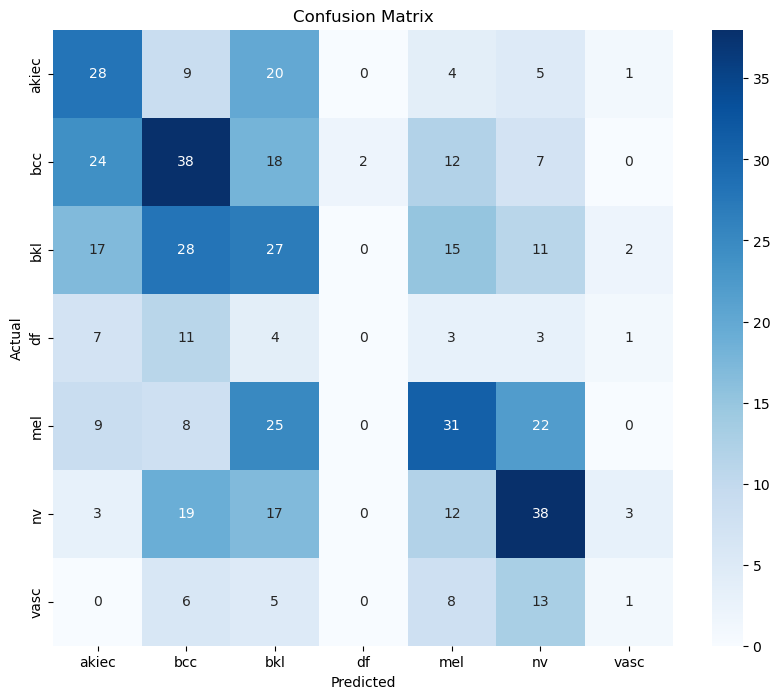

In [23]:
import cv2
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import imgaug.augmenters as iaa

# Define augmentations
augmentation_pipeline = iaa.Sequential([
    iaa.Fliplr(0.5),  # horizontal flip
    iaa.Flipud(0.2),  # vertical flip
    iaa.Add((-10, 10)),  # change brightness
    iaa.Multiply((0.8, 1.2))  # change contrast
])

# Load and preprocess images
def preprocess_image_cnn(img, target_size=(224, 224)):
    img = cv2.resize(img, target_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img.astype(np.uint8)  # Ensure image is uint8
    img = augmentation_pipeline(image=img)  # Apply augmentations
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=-1)
    return img

# Assuming downsampled_data is a pandas DataFrame with 'image_id' and 'dx' columns
preprocessed_images_cnn = []
valid_labels = []
for index, row in downsampled_data.iterrows():
    img_id = row['image_id']
    img_path = None
    for dir in image_dirs:  # image_dirs should be defined elsewhere in your code
        potential_path = os.path.join(dir, f'{img_id}.jpg')
        if os.path.exists(potential_path):
            img_path = potential_path
            break
    if img_path and os.path.exists(img_path):
        img = cv2.imread(img_path)
        if img is not None:
            preprocessed_img = preprocess_image_cnn(img)
            preprocessed_images_cnn.append(preprocessed_img)
            valid_labels.append(row['dx'])
        else:
            print(f"Failed to load image {img_id} from path: {img_path}")

print(f"Successfully preprocessed {len(preprocessed_images_cnn)} images")

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(valid_labels)

# Train/test split for CNN
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(preprocessed_images_cnn, labels_encoded, test_size=0.2, random_state=42)

# Define CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train CNN model
cnn_model.fit(np.array(X_train_cnn), np.array(y_train_cnn), epochs=20, batch_size=32, validation_split=0.1)

# Evaluate CNN model
cnn_metrics = cnn_model.evaluate(np.array(X_test_cnn), np.array(y_test_cnn))
print(f"CNN Accuracy: {cnn_metrics[1]}")

# Predict and evaluate CNN
y_pred_prob_cnn = cnn_model.predict(np.array(X_test_cnn))
y_pred_cnn = np.argmax(y_pred_prob_cnn, axis=1)

print("CNN Classification Report:")
print(classification_report(y_test_cnn, y_pred_cnn, target_names=label_encoder.classes_))
print(f"CNN AUC-ROC: {roc_auc_score(y_test_cnn, y_pred_prob_cnn, multi_class='ovr')}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_cnn, y_pred_cnn)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# CNN without SIFT no augmentations:

Successfully preprocessed 2584 images


C:\Users\Zoiya\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 284ms/step - accuracy: 0.1719 - loss: 3.1329 - val_accuracy: 0.2802 - val_loss: 1.7738
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2564 - loss: 1.7924 - val_accuracy: 0.2850 - val_loss: 1.7204
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 275ms/step - accuracy: 0.3401 - loss: 1.6752 - val_accuracy: 0.3382 - val_loss: 1.6928
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 22s 377ms/step - accuracy: 0.4602 - loss: 1.4749 - val_accuracy: 0.3720 - val_loss: 1.6720
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 24s 415ms/step - accuracy: 0.5898 - loss: 1.1494 - val_accuracy: 0.3237 - val_loss: 1.7712
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 28s 472ms/step - accuracy: 0.7280 - loss: 0.8088 - val_accuracy: 0.3671 - val_loss: 1.8281
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 26s 433ms/step - accuracy: 0.8175 - loss: 0.5503 - val_accuracy: 0.3430 - val_loss: 2.0355
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 383ms/step - accuracy: 0.8751 - loss: 0.3949 - val_accu

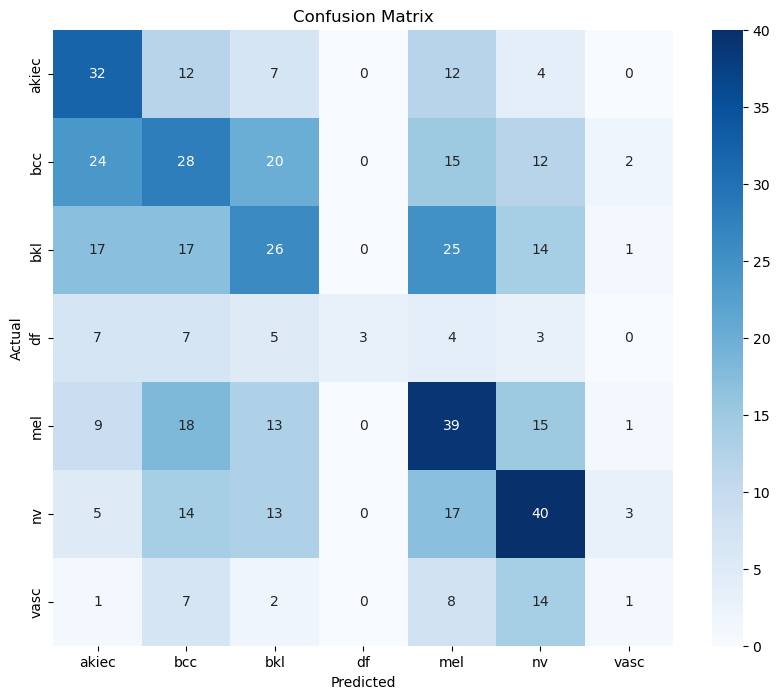

In [24]:
import cv2
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns


# Load and preprocess images
def preprocess_image_cnn(img, target_size=(224, 224)):
    img = cv2.resize(img, target_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=-1)
    return img

# Assuming downsampled_data is a pandas DataFrame with 'image_id' and 'dx' columns
preprocessed_images_cnn = []
valid_labels = []
for index, row in downsampled_data.iterrows():
    img_id = row['image_id']
    img_path = None
    for dir in image_dirs:  # image_dirs should be defined elsewhere in your code
        potential_path = os.path.join(dir, f'{img_id}.jpg')
        if os.path.exists(potential_path):
            img_path = potential_path
            break
    if img_path and os.path.exists(img_path):
        img = cv2.imread(img_path)
        if img is not None:
            preprocessed_img = preprocess_image_cnn(img)
            preprocessed_images_cnn.append(preprocessed_img)
            valid_labels.append(row['dx'])
        else:
            print(f"Failed to load image {img_id} from path: {img_path}")

print(f"Successfully preprocessed {len(preprocessed_images_cnn)} images")

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(valid_labels)

# Train/test split for CNN
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(preprocessed_images_cnn, labels_encoded, test_size=0.2, random_state=42)

# Define CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train CNN model
cnn_model.fit(np.array(X_train_cnn), np.array(y_train_cnn), epochs=20, batch_size=32, validation_split=0.1)

# Evaluate CNN model
cnn_metrics = cnn_model.evaluate(np.array(X_test_cnn), np.array(y_test_cnn))
print(f"CNN Accuracy: {cnn_metrics[1]}")

# Predict and evaluate CNN
y_pred_prob_cnn = cnn_model.predict(np.array(X_test_cnn))
y_pred_cnn = np.argmax(y_pred_prob_cnn, axis=1)

print("CNN Classification Report:")
print(classification_report(y_test_cnn, y_pred_cnn, target_names=label_encoder.classes_))
print(f"CNN AUC-ROC: {roc_auc_score(y_test_cnn, y_pred_prob_cnn, multi_class='ovr')}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_cnn, y_pred_cnn)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# CNN with SIFT:

In [25]:
# Define the list of missing labels
missing_labels = {'ISIC_0026349', 'ISIC_0027269', 'ISIC_0025452'}

# Get the indices of the rows with missing labels
missing_indices = downsampled_data[downsampled_data['image_id'].isin(missing_labels)].index

# Drop these rows from downsampled_data
downsampled_data_cleaned = downsampled_data.drop(missing_indices).reset_index(drop=True)

# Verify the new length
print("New length of downsampled_data:", len(downsampled_data_cleaned))

# Encode labels
labels_cleaned = downsampled_data_cleaned['dx'].values
labels_encoded_cleaned = label_encoder.fit_transform(labels_cleaned)

# Flatten SIFT embeddings
flattened_embeddings = padded_embeddings.reshape(padded_embeddings.shape[0], -1)

# Check lengths to ensure they match
print("Length of flattened_embeddings:", len(flattened_embeddings))
print("Length of labels_encoded_cleaned:", len(labels_encoded_cleaned))

# Reshape flattened embeddings back to original shape
reshaped_embeddings = flattened_embeddings.reshape(-1, max_length, 128)
print(f"Shape of reshaped embeddings: {reshaped_embeddings.shape}")

# Create train/test split with the reshaped embeddings and cleaned labels
X_train, X_test, y_train, y_test = train_test_split(reshaped_embeddings, labels_encoded_cleaned, test_size=0.2, random_state=42)


New length of downsampled_data: 2581
Length of flattened_embeddings: 2581
Length of labels_encoded_cleaned: 2581
Shape of reshaped embeddings: (2581, 100, 128)


Epoch 1/20


C:\Users\Zoiya\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.1822 - loss: 17.4369 - val_accuracy: 0.2174 - val_loss: 1.9687
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1840 - loss: 1.9384 - val_accuracy: 0.2367 - val_loss: 1.9524
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2161 - loss: 1.8803 - val_accuracy: 0.2464 - val_loss: 1.9371
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2411 - loss: 1.8597 - val_accuracy: 0.2174 - val_loss: 1.9224
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2606 - loss: 1.8198 - val_accuracy: 0.1981 - val_loss: 1.9000
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2741 - loss: 1.7718 - val_accuracy: 0.1981 - val_loss: 1.8963
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2849 - loss: 1.7549 - val_accuracy: 0.2367 - val_loss: 1.9031
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3123 - loss: 1.7115 - val_accuracy: 0.2222 - val_loss: 1.

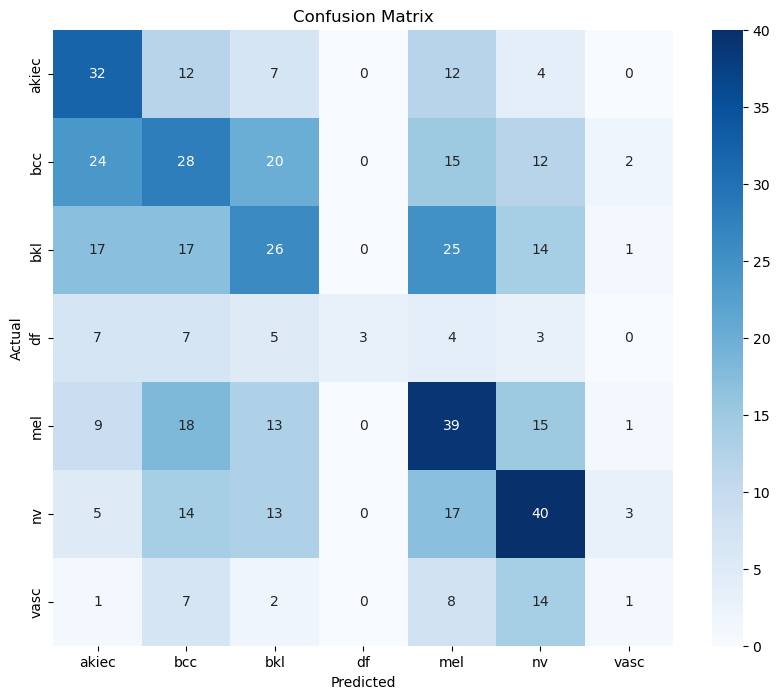

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D

# Define CNN model using SIFT embeddings
cnn_sift_model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(max_length, 128)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

cnn_sift_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train CNN model
cnn_sift_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# Evaluate CNN model
cnn_sift_metrics = cnn_sift_model.evaluate(X_test, y_test)
print(f"CNN with SIFT Embeddings Accuracy: {cnn_sift_metrics[1]}")

# Predict and evaluate CNN with SIFT embeddings
y_pred_prob_cnn_sift = cnn_sift_model.predict(X_test)
y_pred_cnn_sift = np.argmax(y_pred_prob_cnn_sift, axis=1)

print("CNN with SIFT Embeddings Classification Report:")
print(classification_report(y_test, y_pred_cnn_sift, target_names=label_encoder.classes_))
print(f"CNN with SIFT Embeddings AUC-ROC: {roc_auc_score(y_test, y_pred_prob_cnn_sift, multi_class='ovr')}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_cnn, y_pred_cnn)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()